In [13]:
# Identifying Customer Targets (Python)
%matplotlib inline

# import packages for text processing and machine learning
import pandas as pd  # DataFrame structure and operations
import numpy as np  # arrays and numerical processing
import matplotlib.pyplot as plt  # 2D plotting
import statsmodels.api as sm  # logistic regression
import statsmodels.formula.api as smf  # R-like model specification
import patsy  # translate model specification into design matrices
import nltk  # draw on the Python natural language toolkit
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import scipy.stats as stats
from scipy.stats import uniform
from warnings import filterwarnings
filterwarnings('ignore')
from bs4 import BeautifulSoup
from pandas.io.html import read_html
import pandas_profiling
import PyPDF2
import tabula
import csv
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup
#import cookiejar
import fuzzymatcher
import sqlite3
import random
import timeit
import pandas as pd
import numpy as np
#from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# import module 
from geopy.geocoders import Nominatim
# initialize Nominatim API  
geolocator = Nominatim(user_agent="geoapiExercises")
import geopandas

from uszipcode import SearchEngine
#search = SearchEngine(simple_zipcode=True) this a problem?
from uszipcode import Zipcode
import numpy as np


import pandas as pd
from pathlib import Path
import chart_studio.plotly as py
import plotly.express as px
import plotly.figure_factory as ff
#pd.options.plotting.backend = "plotly"
import numpy as np
import pickle

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jake\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:


"""
    ==== NOTES ==== 
- needed to fix VEHICLE.csv by copying all content and pasting into another file.
- created state_mappings.csv from FARS Analytical User's Manual, 1975-2018.pdf which gives id->state name mappings
- created soe_mappings.csv from the FARS manual, giving Series Of Events -> name mappings
- some territories are missing from STATE data: (43) Puerto Rico, (52) Virgin Islands, and some are just missing (14, 7, 3)
  - however, some of this data is likely available in the "Puerto Rico" section of the FTP site
# installed chart_studio (pip install chart_studio)
- some data are mislabeled in the Users Manual vs CSV... ACCIDENT.csv has HOSP_MN, but user guide has HOSP_MIN
- data dictionary is in the user manual on page 20
- many of the "99-as-nans" values throw off histograms
# installed orca: conda install -c plotly plotly-orca

- LONGITUD is misspelled, (should be LONGITUDE)
"""

def load_csv_as_dict_df(csv_dir):
    csv_dir = Path(csv_dir)
    d = {}
    for csv in csv_dir.glob('*.csv'):
        try:
            d[csv.stem] = pd.read_csv(csv, low_memory=False)
        except:
            print(f"failed to load {csv}")
    return d


def matrix_correlation_plot(df, title="", save_plots=False, fig_output=""):
    fig_output = Path(fig_output)
    fig = px.scatter_matrix(df, title=title)
    if save_plots:
        fig.write_image(str(Path(fig_output / f"{title}.png").absolute()))
    else:
        fig.show()

def matrix_scatter_plot(df):
    df_new = df.copy()
    for col in df_new.columns:
        df_new[col] = df_new[col].value_counts()

    fig = ff.create_scatterplotmatrix(df, diag='histogram', index="STATE", height=1000, width=1000)
    py.iplot(fig, filename='Histograms along Diagonal Subplots')

def all_histograms(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
            df.hist(column=col)
        except ValueError:
            pass
            #df[col].count()
        finally:
            print(f"column {col} not representable")

def filter_state(df, state_name, df_state_map, state_col='STATE'):
    id = df_state_map[df_state_map['name'] == state_name]['id']
    return df[df[state_col] == id]

In [27]:
# set up directories
base_dir = Path(r'C:\Users\Jake\Desktop\Syracuse\IST 718 Big Data Analytics\Final Project')
nhtsa_path = Path(base_dir / 'FARS2018NationalCSV')
nhtsa_plot_output_path = Path(base_dir / 'nhtsa_plots')
#nhtsa_plot_output_path.mkdir(exist_ok=True)
pkl_path = Path(base_dir / 'dict_df.pkl')  # if not present, will try loading from csvs
state_csv_path = Path(base_dir / 'state_mappings.csv')
soe_csv_path = Path(base_dir / 'soe_mappings.csv')

# including shapefile directories, from here: https://data.ca.gov/dataset/ca-geographic-boundaries
path_shape = Path(base_dir / 'shapefiles')
path_shape_CA = Path(path_shape / 'ca-state-boundary\CA_State_TIGER2016.shp')
path_shape_CA_counties = Path(path_shape / 'ca-county-boundaries\CA_Counties_TIGER2016.shp')

In [32]:
# load state mappings into df
df_state_mappings = pd.read_csv(state_csv_path)  # 'id' -> 'name'
print(df_state_mappings)
# and soe mappings
df_soe_mappings = pd.read_csv(soe_csv_path)  #  'SOE'  ->  'NAME'

if False:#pkl_path.exists() and pkl_path.is_file():
    dict_df = pickle.load(pkl_path.open('rb'))
else:
    dict_df = load_csv_as_dict_df(nhtsa_path)
    pickle.dump(dict_df, pkl_path.open('wb'))

print(pkl_path.exists())

print(f"{len(dict_df)} csv files loaded")
print(f"{sum([len(v.columns) for k,v in dict_df.items()])} columns")
print(f"{sum([len(v) for k, v in dict_df.items()])} rows")

# joining a few important data fields
df_person = dict_df.get('PERSON')  # 83,626 rows
df_vehicle = dict_df.get('VEHICLE')  # 51,872 rows
df_accident = dict_df.get('ACCIDENT')  # 33,654 rows
df_maneuver = dict_df.get('MANEUVER')
df_factor = dict_df.get('FACTOR')
df_vevent = dict_df.get('VEVENT')  # 144,699 rows (contains leterally all the information that VSOE does, and 3 more columns)

print(df_person.head()) #get this working

# join accident with vehicle ('ST_CASE')
df = df_person.join(df_vehicle, on='ST_CASE', how='left', lsuffix='_per', rsuffix='_veh') \
    .rename(columns={
            'ST_CASE_per': 'ST_CASE',
            'STATE_per': 'STATE',
            'VEH_NO_veh': 'VEH_NO'
    })

# add state names (verified: all rows have a state name and ID at this point)
df = df.merge(df_state_mappings, left_on='STATE', right_on='id')\
    .drop(columns='id')\
    .rename(columns={'name': 'STATE_NAME'})

# join case and vehicle with person (this results in ONLY drivers), no passengers ('ST_CASE' and 'VEH_NO')
df = df.join(df_accident, on='ST_CASE', how='left', lsuffix='_per_veh', rsuffix='_acc') \
    .rename(columns={
            'ST_CASE_per_veh': 'ST_CASE',
            'STATE_per_veh': 'STATE'
    })

#df = df.join(df_factor, on=['ST_CASE', 'VEH_NO'], how='left', lsuffix='_per_veh_acc', rsuffix='_fac')
df = df.merge(df_factor, on=['ST_CASE', 'VEH_NO'], how='left')

df = df.merge(df_maneuver, on=['ST_CASE', 'VEH_NO'], how='left')

# define which versions of columns we want to keep
df = df.drop(columns=['MONTH', 'DAY', 'HOUR', 'MINUTE'])
df = df.rename(columns={
    'MONTH_per': 'MONTH',
    'DAY_per': 'DAY',
    'HOUR_per': 'HOUR',
    'MINUTE_per': 'MINUTE'
})
# use sane values
df['HOUR'] = np.where(df['HOUR'] > 23, 0, df['HOUR'])
df['MINUTE'] = np.where(df['MINUTE'] > 59, 0, df['MINUTE'])


    id                         name
0    1                      Alabama
1   31                     Nebraska
2    2                       Alaska
3   32                       Nevada
4    4                      Arizona
5   33                New Hampshire
6    5                     Arkansas
7   34                   New Jersey
8    6                   California
9   35                   New Mexico
10   8                     Colorado
11  36                     New York
12   9                  Connecticut
13  37               North Carolina
14  10                     Delaware
15  38                 North Dakota
16  11         District of Columbia
17  39                         Ohio
18  12                      Florida
19  40                     Oklahoma
20  13                      Georgia
21  41                       Oregon
22  15                       Hawaii
23  42                 Pennsylvania
24  16                        Idaho
25  43                  Puerto Rico
26  17                     I

ValueError: Joining multiple DataFrames only supported for joining on index

In [35]:
df_accident.sum()


STATE                                                    916120
ST_CASE                                              9186181203
VE_TOTAL                                                  53182
VE_FORMS                                                  51872
PVH_INVL                                                   1310
PEDS                                                       7802
PERNOTMVIT                                                 8190
PERMVIT                                                   75436
PERSONS                                                   75824
COUNTY                                                  3088200
CITY                                                   43516027
DAY                                                      522171
MONTH                                                    223841
YEAR                                                   67913772
DAY_WEEK                                                 138258
HOUR                                    

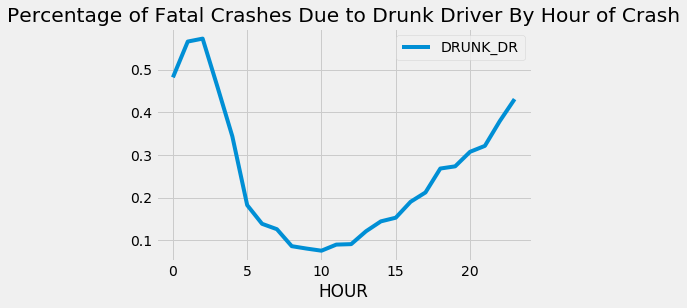

In [41]:
df_accident_filt_bad_hour=df_accident[df_accident['HOUR'] < 24]
df_accident_filt_bad_hour.groupby('HOUR').aggregate({'DRUNK_DR':np.mean}).plot.line(title = 'Percentage of Fatal Crashes Due to Drunk Driver By Hour of Crash')

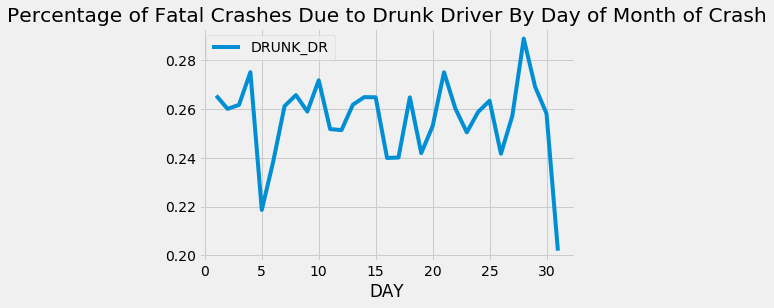

In [39]:
df_accident_filt_bad_day=df_accident[df_accident['DAY'] < 32]

#does this relate to when people get paid - 

df_accident_filt_bad_day.groupby('DAY').aggregate({'DRUNK_DR':np.mean}).plot.line(title = 'Percentage of Fatal Crashes Due to Drunk Driver By Day of Month of Crash')

In [40]:
df_accident.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,2,1,1,0,0,1,1,121,...,99,6,15,88,88,0,0,0,1,0
1,1,10002,1,1,0,0,0,2,2,127,...,99,0,59,88,88,20,0,0,2,0
2,1,10003,2,2,0,0,0,2,2,21,...,99,23,10,99,99,0,0,0,1,0
3,1,10004,1,1,0,0,0,2,2,3,...,99,13,14,88,88,0,0,0,1,0
4,1,10005,2,2,0,0,0,2,2,73,...,99,7,28,88,88,0,0,0,1,0


In [47]:
df2 = df_accident.copy()
df2['had_drunk_driver'] = df2['DRUNK_DR'] > 0
df2 = df2.rename(columns={'FATALS':'num_fatality'})

df2.groupby('had_drunk_driver').aggregate({'num_fatality':np.mean})

,num_fatality
had_drunk_driver,
False,1.078220
True,1.110872


In [58]:
from scipy import stats

stats.ttest_ind(df2[df2.had_drunk_driver == True]['num_fatality'],df2[df2.had_drunk_driver == False]['num_fatality'])

Ttest_indResult(statistic=7.209195235091606, pvalue=5.746712002894156e-13)

In [48]:
df2 = df2.rename(columns={'PERNOTMVIT':'num_ped'})
df2.groupby('had_drunk_driver').aggregate({'num_ped':np.mean})



,num_ped
had_drunk_driver,
False,0.294520
True,0.089032


In [59]:
stats.ttest_ind(df2[df2.had_drunk_driver == True]['num_ped'],df2[df2.had_drunk_driver == False]['num_ped'])

Ttest_indResult(statistic=-32.663535985987174, pvalue=2.0660402620654453e-230)

In [49]:
df2 = df2.rename(columns={'VE_FORMS':'num_vehicle'})
df2.groupby('had_drunk_driver').aggregate({'num_vehicle':np.mean})

,num_vehicle
had_drunk_driver,
False,1.566449
True,1.465569


In [60]:
stats.ttest_ind(df2[df2.had_drunk_driver == True]['num_vehicle'],df2[df2.had_drunk_driver == False]['num_vehicle'])

Ttest_indResult(statistic=-10.318323242122297, pvalue=6.343569120461464e-25)